In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from sbins import *



# Sparse Bayesian Identification of Nonlinear Systems (SBINS)

This notebook demonstrates the basic idea of adapting the original work on "Sparse Identification of Nonlinear Systems" (Branton et al. 2016) into a Bayesian setting. We demonstrate the approach in the context of the discovery on nonlinear material consitutive laws in material science applications.

We are interesting in learning the relationship between stress $\sigma$ and strain ($\epsilon$) in a material for experimental results. One way to do this to learn the stiffness, i.e.
$$
\frac{d\sigma}{d\epsilon} = f(\epsilon)
$$
We can think of using a function approximation method for learning $f(\epsilon)$ based on experimental data provided for $\frac{d\sigma}{d\epsilon}$ which can be computed by numerically differentiating the $\epsilon - \sigma$ curve obtain from an experiment on a material.

SINDy is a method which postulates a function form for $f(\epsilon)$ for a example a polynomial (considered in this notebook).
$$
f(\epsilon) \approx = \sum_{i=0}^M a_i \epsilon^i
$$
for which we take $M$ large. Naturally a choice of large $M$ would make the approach very vunerable to overfitting, further more, the optimal solution is likely to have small contributions from all terms of the polynomial. It is therefore natural to regularize the problem, and consider sparse regression; for example using LASSO.

This could be directly applied to the problem at hand, yet it does not account for the fact that there is inherit uncertainty due to natural variation in the material from sample to sample, but also noise associated with measurement uncertainty. Therefore to capture this uncertainty is natural to be assign probability distributions to the coefficents $a_i$. In the same frame, we would also like to invoke sparsity in the model, and therefore here we extend SINDy, but replace LASSO with Sparse Bayesian Regression methods.

In [2]:
np.random.seed(123)
N = 5
N_perExperiment = 25
featureOrder = 7
s = 0.05

## Generating Synthetic Exeperimental Data for Nonlinear Elasticity

In [3]:
def experiment(x,s):
    k1 = np.random.normal(1.0, 0.2)
    k2 = np.random.normal(2.0, 0.2)
    return k1 * x + k2 * x**3 + np.random.normal(0.0, s, x.shape)

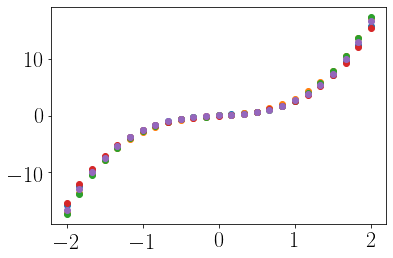

In [25]:
x = np.linspace(-2.0, 2., N_perExperiment)

Y = experiment(x,s)
fig, ax = plt.subplots()
ax.plot(x,Y,'o')
for i in range(N - 1):   
    tmp = experiment(x, s)
    Y = np.vstack((Y,tmp))
    ax.plot(x, tmp, 'o')
   
Y = Y.T # Transpose so correct shape for differentiation later

plt.show()

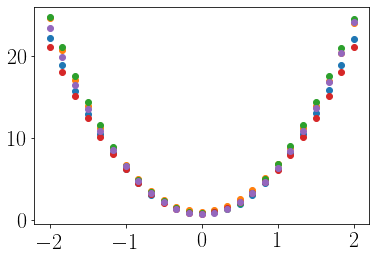

In [26]:
sfd = SmoothedFiniteDifference(smoother_kws={'polyorder': 3, 'window_length': 9})

dYdX = sfd._differentiate(Y, x)

fig, ax = plt.subplots()

for i in range(N):
    
    ax.plot(x, dYdX[:,i], 'o')
    
plt.show()

dYdX = dYdX.flatten('F') # Flattern Matrix of Data into a Column Vector for pymc3 implementation

In [27]:
# Build Polynomial Feature Library

# [1, X, X**2, ... , X**7]

X = np.ones(N * x.size)

for i in range(1,featureOrder+1):
    
    tmp = np.matlib.repmat(x, 1, N)
    
    X = np.vstack((X, tmp ** i))


In [28]:
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

#Guess as to number of 'meaningful' gradients we have- order of magnitude is okay!
m0=3
#Other constants for the model
slab_scale = 3
slab_scale_squared=slab_scale*slab_scale
slab_degrees_of_freedom=25
half_slab_df=slab_degrees_of_freedom*0.5

M = featureOrder + 1

with pm.Model() as finnish_horseshoe_prior:

    tau0 = (m0 / (M - m0)) * (s / np.sqrt(1.0 * N))

    #Non-centered distributions- loc=0, width=1 then shift/stretch afterwards
    gradient_tilde = pm.Normal('gradient_tilde', mu=0, sd=1, shape=M, testval=0.1)
    lamda = pm.HalfCauchy('lamda', beta=1, shape=M, testval=1.0)
    tau_tilde = pm.HalfCauchy('tau_tilde', beta=1, testval=0.1)
    c2_tilde = pm.InverseGamma('c2_tilde', alpha=half_slab_df, beta=half_slab_df, testval=0.5)

    #Do the shifting/stretching
    tau=pm.Deterministic('tau', tau_tilde*tau0)
    c2=pm.Deterministic('c2',slab_scale_squared*c2_tilde)
    lamda_tilde =pm.Deterministic('lamda_tilde', pm.math.sqrt((c2 * pm.math.sqr(lamda) / (c2 + pm.math.sqr(tau) * pm.math.sqr(lamda)) ))) 

    #Linear model variables as before
    gradient = pm.Deterministic('m', tau * lamda_tilde * gradient_tilde)
    mu=pm.Deterministic('mu', pm.math.dot(X.T, gradient))
    sigma=pm.Normal('sig', mu=0.0, sd=2.0, testval=1.0)

    y_inference=pm.Normal('y', mu=mu, sd=sigma, observed=dYdX)

    #Nuts with changed defaults
    trace=pm.sample(2000, init='advi+adapt_diag', tune=1000, target_accept=0.995)

Running on PyMC3 v3.11.1


/Users/td336/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 23700
Interrupted at 23,699 [11%]: Average Loss = 5.9407e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, c2_tilde, tau_tilde, lamda, gradient_tilde]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 535 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
trace['m'][:,0].shape

(8000,)

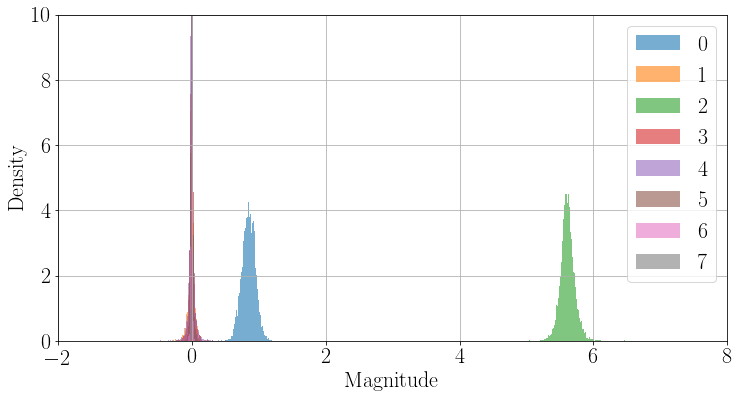

In [32]:
fig = plt.figure(figsize=(12,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

for i in range(featureOrder + 1):

    plt.hist(trace['m'][:, i] , 100, density=True, alpha=0.6, label = str(i))


plt.xlim(-2, 8.0)
plt.ylim(0.0, 10.0)
plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.grid()
plt.legend()    